# Comparison of span vs other peak calling tools

Method based on F score described in original paper:
Koohy H, Down TA, Spivakov M, Hubbard T (2014) 
A Comparison of Peak Callers Used for DNase-Seq Data. 
PLoS ONE 9(5): e96303. doi:10.1371/journal.pone.0096303

http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0096303

## Requirements

* span.jar
* java8
* bedtools
* wget
* awk
* ~20G free space to download all the required bed and bam files

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import sys
from os import listdir
def run(cmd):
    print(cmd)
    if os.system(cmd) != 0:
        sys.exit(1)

Download all the "Reference peaks set" mentioned in http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0096303



In [2]:
PATH = os.path.expanduser('~/data/2023_opendnase')
RESOURCE = 'http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeSydhTfbs'
CELLS = ['GM12878', 'HelaS3', 'K562']

In [31]:
! mkdir ~/data/2023_opendnase
! cd ~/data/2023_opendnase && wget "http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0096303.s007" -O supplementary.zip
! cd ~/data/2023_opendnase && unzip -x supplementary.zip

mkdir: cannot create directory ‘/home/jetbrains/data/2023_opendnase’: File exists
URL transformed to HTTPS due to an HSTS policy
--2023-12-12 13:19:14--  https://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0096303.s007
Resolving journals.plos.org (journals.plos.org)... 35.190.43.188
Connecting to journals.plos.org (journals.plos.org)|35.190.43.188|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /plosone/article/file?id=info%3Adoi/10.1371/journal.pone.0096303.s007&type=supplementary [following]
URL transformed to HTTPS due to an HSTS policy
--2023-12-12 13:19:14--  https://journals.plos.org/plosone/article/file?id=info%3Adoi/10.1371/journal.pone.0096303.s007&type=supplementary
Reusing existing connection to journals.plos.org:443.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/plos-corpus-prod/10.1371/journal.pone.0096303/1/pone.0096303.s007.zip?X-Goog-Algorithm=GOOG

Now that we have Supplemetary_Data/GM12878.txt, etc, we can download all the peaks automatically.
Files are available here: http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0096303.s007

In [3]:
import pandas as pd

for cell in tqdm(CELLS):
    print(cell)
    os.mkdir(PATH + '/' + cell)
    df = pd.read_csv(PATH + f'/Supplementary_Data/{cell}.txt', sep=' ', header=None)
    df.columns = ['file', 'checksum']
    for f in df['file']:
        ! cd {PATH} && wget {RESOURCE}/{f} -P {cell}

  0%|          | 0/3 [00:00<?, ?it/s]

GM12878


FileExistsError: [Errno 17] File exists: '/home/jetbrains/data/2023_opendnase/GM12878'

Now we should all the reference peaks using Bedops as described in the article, however Bedops FAILS with segfault.

Bedtools for the rescue!

In [ ]:
# Lets merge them and filter chr22 to get reference peaks
CELLS = ['GM12878', 'HelaS3', 'K562']
! mkdir {PATH}/peaks
for cell in tqdm(CELLS):
    ! cd {PATH} && cat {cell}/*.gz > {cell}_all.bed
    ! bedtools sort -i {PATH}/{cell}_all.bed > {PATH}/{cell}_sorted.bed
    ! bedtools merge -i {PATH}/{cell}_sorted.bed > {PATH}/{cell}_peaks.bed
    run(f'awk \'$1=="chr22" {{print}}\' {PATH}/{cell}_peaks.bed > {PATH}/peaks/{cell}_peaks_chr22.bed')
! rm *_all.bed *_sorted.bed *_peaks.bed

Download and convert reads.

In [ ]:
! wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseK562AlnRep1.bam -O {PATH}/K562.bam
! wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseGm12878AlnRep1.bam -O {PATH}/GM12878.bam
! wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeUwDnase/wgEncodeUwDnaseHelas3AlnRep1.bam -O {PATH}/HelaS3.bam

print('Lets convert downloaded bam files to bed')
for bam in tqdm([f for f in listdir(PATH) if f.endswith(".bam")]):
    ! bamToBed -bed12 -i {PATH}/{bam} > {PATH}/{bam}.bed

Now we can launch span to get enrichment for obtained bed tracks.

In [ ]:
# ! cd {PATH} && wget https://download.jetbrains.com/biolabs/span/span-1.4.6197.jar
! cd {PATH} && wget http://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes

In [4]:
! mkdir {PATH}/span
FDRS = [1e-40, 1e-20, 1e-15, 1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 0.05, 0.1, 0.2, 0.5]
for reads in tqdm([f for f in listdir(PATH) if f.endswith(".bam.bed")]):
    for fdr in FDRS:
        print(f'Processing {reads} FDR={fdr}')
        ! cd {PATH} && java -jar span.jar analyze -cs hg19.chrom.sizes -t {reads} --peaks span/{reads}_{fdr}_span.bed --bin 100 --fdr {fdr} --keep-cache

mkdir: cannot create directory ‘/home/jetbrains/data/2023_opendnase/span’: File exists


  0%|          | 0/3 [00:00<?, ?it/s]

Processing K562.bam.bed FDR=1e-40
[Oct 16, 2024 16:53:42] SPAN 2.0.build built on October 16, 2024
[Oct 16, 2024 16:53:42] COMMAND: analyze -cs hg19.chrom.sizes -t K562.bam.bed --peaks span/K562.bam.bed_1e-40_span.bed --bin 100 --fdr 1e-40 --keep-cache
[Oct 16, 2024 16:53:42] WORKING DIR: /home/jetbrains/data/2023_opendnase
[Oct 16, 2024 16:53:42] LOG: /home/jetbrains/data/2023_opendnase/K562.bam.bed_1e-40_span.log
[Oct 16, 2024 16:53:42] TREATMENT: /home/jetbrains/data/2023_opendnase/K562.bam.bed
[Oct 16, 2024 16:53:42] CONTROL: none
[Oct 16, 2024 16:53:42] BLACKLIST FILE: null
[Oct 16, 2024 16:53:42] WORKING DIR: /home/jetbrains/data/2023_opendnase
[Oct 16, 2024 16:53:42] CHROM.SIZES: /home/jetbrains/data/2023_opendnase/hg19.chrom.sizes
[Oct 16, 2024 16:53:42] BIN: 100
[Oct 16, 2024 16:53:42] FRAGMENT: auto
[Oct 16, 2024 16:53:42] KEEP DUPLICATES: false
[Oct 16, 2024 16:53:42] CONVERGENCE THRESHOLD: 1.0E-4
[Oct 16, 2024 16:53:42] MAX ITERATIONS: 10
[Oct 16, 2024 16:53:42] MODEL TYPE:

    Let us perform intersection of reference peaks with span ones.

In [5]:
import tempfile
import pandas as pd
from pandas import DataFrame

def bed_length(cell_file):
    t = pd.read_csv(cell_file,  sep='\t', header=None)
    if len(t) > 0:
        return (t[2] - t[1]).sum()
    return 0

def lines(cell_file):
    t = pd.read_csv(cell_file,  sep='\t', header=None)
    return len(t)

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

t = tempfile.mktemp()

results = DataFrame(columns=['cell', 'fdr', 'ref_peaks', 'ref_length',
                             'span_peaks', 'span_length', 'intersection_peaks', 'intersection_length'])
for cell in tqdm(CELLS):
    cell_file = sorted_file(f'{PATH}/peaks/{cell}_peaks_chr22.bed')
    cell_peaks = lines(cell_file)
    cell_peaks_length = bed_length(cell_file)    
    
    for reads in [f for f in listdir(PATH) if f.endswith(".bam.bed")]:
        for fdr in FDRS: 
            file = f'{PATH}/span/{reads}_{fdr}_span.bed'
            if cell not in file:
                continue
            ! cat {file} | grep chr22 > {t}
            t = sorted_file(t)
            span_peaks = lines(t)
            span_length = bed_length(t)
            intersection_file = f'{PATH}/peaks/intersection_{cell}_{fdr}.bed'
            ! bedtools intersect -a {cell_file} -b {t} -wo > {intersection_file}
            intersection_peaks = lines(intersection_file)
            intersection_length = int(last_col(intersection_file).sum())
            results.loc[len(results)] = [cell, fdr, cell_peaks, cell_peaks_length,
                                         span_peaks, span_length, intersection_peaks, intersection_length]
results

  0%|          | 0/3 [00:00<?, ?it/s]

,cell,fdr,ref_peaks,ref_length,span_peaks,span_length,intersection_peaks,intersection_length
0,GM12878,1.000000e-40,6253,3107182,616,1499480,1188,1075061
1,GM12878,1.000000e-20,6253,3107182,895,1695760,1492,1185706
2,GM12878,1.000000e-15,6253,3107182,1001,1761580,1599,1218236
3,GM12878,1.000000e-10,6253,3107182,1165,1834200,1750,1256979
4,GM12878,1.000000e-08,6253,3107182,1247,1866400,1819,1273317
5,GM12878,1.000000e-06,6253,3107182,1339,1903630,1900,1294131
6,GM12878,1.000000e-04,6253,3107182,1476,1953550,2008,1318904
7,GM12878,1.000000e-03,6253,3107182,1540,1974560,2049,1327314
8,GM12878,5.000000e-02,6253,3107182,1690,2015050,2135,1343296
9,GM12878,1.000000e-01,6253,3107182,1731,2025410,2155,1346491


Now that we have both reference peaks, span output and their intersection length, we can compute `TP`, `FP` and `FN` values.

In [6]:
results['TP'] = results['intersection_length']
results['FP'] = results['span_length'] - results['intersection_length']
results['FN'] = results['ref_length'] - results['intersection_length']
results['Spec'] = results['TP'] / (results['TP'] + results['FP'])
results['Sen'] = results['TP'] / (results['TP'] + results['FN'])
results.head(1)

,cell,fdr,ref_peaks,ref_length,span_peaks,span_length,intersection_peaks,intersection_length,TP,FP,FN,Spec,Sen
0,GM12878,1.000000e-40,6253,3107182,616,1499480,1188,1075061,1075061,424419,2032121,0.716956,0.345992


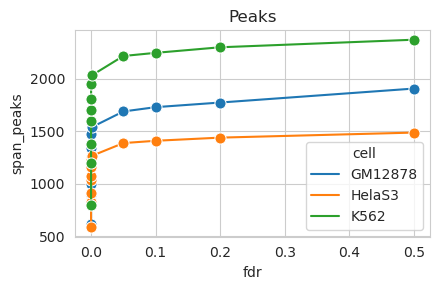

In [7]:
import seaborn as sns
plt.figure(figsize=(4.5, 3))
g_results = sns.lineplot(data=results,
                         x='fdr', y='span_peaks', hue='cell',
                         errorbar='se', marker='o', markersize=8)
g_results.axes.title.set_text(f'Peaks')
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me1_jaccard2.pdf', bbox_inches='tight', dpi=300)
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

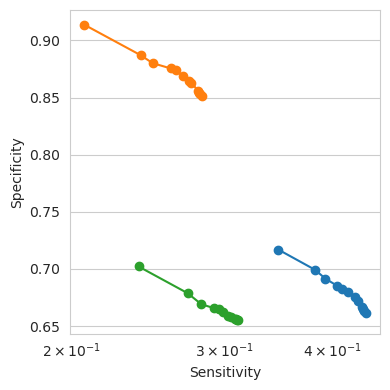

In [8]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
for cell in tqdm(CELLS):
    t = results[results['cell'] == cell].copy()
    t.sort_values(by=['Sen', 'Spec'], inplace=True)
    plt.plot(t['Sen'], t['Spec'], marker='o', label=cell)
ax.set(xscale='log')
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.tight_layout()
plt.show()

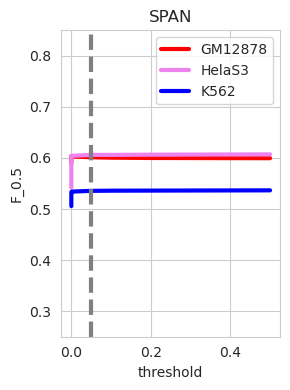

In [9]:
CELLS = ['GM12878', 'HelaS3', 'K562']

def Fb(b, spec, sen):
    return (1 + b*b) * spec * sen / (b * b * spec + sen)

plt.figure(figsize=(3, 4))
ax = plt.axes()
Beta = 0.5
colors = {'GM12878': 'red', 'K562': 'blue', 'HelaS3':'violet'}
plt.title('SPAN')
plt.xlabel('threshold')
plt.ylabel('F_0.5')
for cell in CELLS:
    r = results[(results['cell'] == cell)]
    plt.plot(r['fdr'], Fb(Beta, r['Spec'], r['Sen']), linewidth=3.0, c=colors[cell], label=cell)
plt.axvline(x=0.05, linewidth=3.0, c='grey', linestyle='--')
plt.ylim(0.25, 0.85)
# ax.set(xscale='log')
plt.tight_layout()
plt.legend()
plt.show()

### Now we are ready to compare performance score F
<img src="SPAN Comparison Opendnase.png">